for Swati-san's microglia data, and practice for MicrogliaTrackingGUI development

In [1]:
import sys
import os

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication
from optic.config import *
from optic.controls import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class MicrogliaImageGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "SUITE2P_ROI_CHECK"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]
        self.app_key_pri = self.app_keys[0]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # layout for file load
        self.layout_file_load = QVBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # layout for main UI
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)
        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
        else:
            QMessageBox.warning(self, "File Load Error", "Failed to load the file.")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            clearLayout(self.layout_main_ui)
        
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()

        self.setupUI_done = True

    def loadData(self):
        success = self.data_manager.loadTiffStack(
            key_app=self.app_key_pri,
            path_tiff=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_tiff"].text(),
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1)

    def setupControls(self):
        self.control_manager.view_controls[self.app_key_pri] = ViewControl(
            key_app=self.app_key_pri,
            q_view=self.widget_manager.dict_view[self.app_key_pri], 
            q_scene=self.widget_manager.dict_scene[self.app_key_pri], 
            data_manager=self.data_manager, 
            widget_manager=self.widget_manager,
            config_manager=self.config_manager,
            control_manager=self.control_manager,
        )
        self.control_manager.view_controls[self.app_key_pri].setViewSize()
        pass

    """
    makeLayout Function; Component
    return -> Layout
    """
    "Upper Left"
    def makeLayoutComponentImageView(self):
        layout = makeLayoutViewWithZTSlider(
            self.widget_manager, 
            self.app_key_pri,
            slider_z=True,
            slider_t=True,
            key_label_z=f"{self.app_key_pri}_plane_z",
            key_label_t=f"{self.app_key_pri}_plane_t",
            key_slider_z=f"{self.app_key_pri}_plane_z",
            key_slider_t=f"{self.app_key_pri}_plane_t",
            stack_size_z=self.data_manager.getSizeOfZ(self.app_key_pri),
            stack_size_t=self.data_manager.getSizeOfT(self.app_key_pri),
            )
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastSlider(self):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{self.app_key_pri}_{channel}", 
                key_checkbox=f"{self.app_key_pri}_{channel}", 
                key_slider=f"{self.app_key_pri}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))
        layout.addLayout(layout_channel)
        return layout

    "Upper Right"


    "Bottom"
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()

        # LineEdit
        list_label = ["Microglia tiff image file path"]
        list_key = [f"{self.app_key_pri}_path_tiff"]
        for label, key in zip(list_label, list_key):
            layout.addLayout(makeLayoutLoadFileWidget(
                self.widget_manager, 
                label=label, 
                key_label=key, 
                key_lineedit=key, 
                key_button=key
            ))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    """
    makeLayout Function; Section

    """
    def makeLayoutSectionLeftUpper(self):
        return
    
    def makeLayoutSectionRightUpper(self):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentImageView())
        layout.addLayout(self.makeLayoutComponentContrastSlider())
        return layout

    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout

    """
    bindFunc Function
    """
    def bindFuncFileLoadUI(self):        
        list_key = [f"{self.app_key_pri}_path_tiff"]
        list_filetype = [Extension.TIFF]
        for key, filetype in zip(list_key, list_filetype):
            bindFuncLoadFileWidget(
                q_widget=self, 
                q_button=self.widget_manager.dict_button[key], 
                q_lineedit=self.widget_manager.dict_lineedit[key], 
                filetype=filetype
            )

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])

    def bindFuncAllWidget(self):
        self.widget_manager.dict_button[f"help"].clicked.connect(lambda: self.control_manager.view_controls[self.app_key_pri].updateView())

        # Z,T plane slider
        bindFuncPlaneZSlider(self.widget_manager.dict_slider[f"{self.app_key_pri}_plane_z"], self.control_manager.view_controls[self.app_key_pri])
        bindFuncPlaneTSlider(self.widget_manager.dict_slider[f"{self.app_key_pri}_plane_t"], self.control_manager.view_controls[self.app_key_pri])


if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = MicrogliaImageGUI()
    gui.show()
    sys.exit(app.exec_())

d:\optic\optic\visualization\view_visual.py:175: RuntimeWarning: invalid value encountered in scalar divide
  min_val_norm = (min_val - image_min) / (image_max - image_min)
d:\optic\optic\visualization\view_visual.py:176: RuntimeWarning: divide by zero encountered in scalar divide
  max_val_norm = (max_val - image_min) / (image_max - image_min)
d:\optic\optic\visualization\view_visual.py:182: RuntimeWarning: invalid value encountered in cast
  image_adjusted = (image_contrasted * 255).astype(np.uint8)


SystemExit: 0

c:\Users\HyperPC_Smee\anaconda3\envs\itkelastix\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
gui.control_manager.view_controls[gui.app_key_pri].im_dtype == np.uint16

True

In [4]:
gui.data_manager.dict_tiff[gui.app_key_pri].dtype == np.uint16

True

In [1]:
im

NameError: name 'im' is not defined

In [45]:
import numpy as np
from PIL import Image

im1 = gui.data_manager.dict_tiff[gui.app_key_pri][:, :, 0, 20, 0]
im2 = gui.data_manager.dict_tiff[gui.app_key_pri][:, :, 1, 20, 0]

img = np.zeros((im1.shape[0], im1.shape[1], 3), dtype=im1.dtype)
img = np.zeros((im1.shape[0], im1.shape[1], 3), dtype=np.uint8)
img[:, :, 0] = im1
img[:, :, 2] = im2

# PILイメージに変換 (uint16のまま)
pil_img = Image.fromarray(img, mode='RGB')

# 画像を表示
pil_img.show()

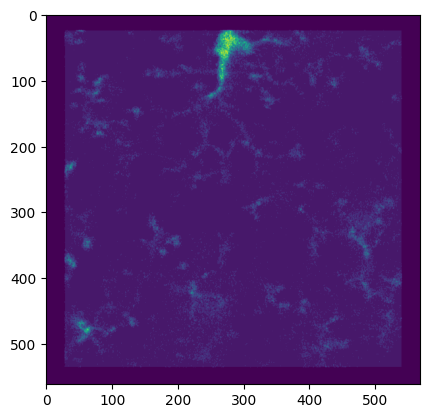

In [20]:
import matplotlib.pyplot as plt
im = gui.control_manager.view_controls[gui.app_key_pri].bg_image[:, :, 1]

plt.imshow(im, vmin=0, vmax=16)
plt.show()

In [16]:
np.mean(im)

0.3470826441448215

In [40]:
im.min()

0

In [10]:
dtype = gui.data_manager.dict_tiff["pri"].dtype

In [11]:
gui.data_manager.dict_tiff["pri"].astype(dtype)

array([[[[[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          ...,
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]],

         [[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          ...,
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]]],


        [[[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          ...,
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]],

         [[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          ...,
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]]],


        [[[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          ...,
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]],

         [[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          ...,
     